# Build Earthquake Catalog

In this final notebook, we read the matched-filter database, remove the multiple detections and write a clean earthquake catalog in a csv file.

In [1]:
import BPMF
import glob
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from tqdm import tqdm
from time import time as give_time

n_CPUs = 12
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

In [2]:
# PROGRAM PARAMETERS
NETWORK_FILENAME = "network.csv"
TEMPLATE_DB = "template_db"
MATCHED_FILTER_DB = "matched_filter_db"
CHECK_SUMMARY_FILE = False
PATH_MF = os.path.join(BPMF.cfg.OUTPUT_PATH, MATCHED_FILTER_DB)
DATA_FOLDER = "preprocessed_2_12"

In [3]:
# read network metadata
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Read the detected events' metadata for each template

In [4]:
# template filenames
template_filenames = glob.glob(os.path.join(BPMF.cfg.OUTPUT_PATH, TEMPLATE_DB, "template*"))
template_filenames.sort()

# initialize the template group
template_group = BPMF.dataset.TemplateGroup.read_from_files(template_filenames, net)
template_group.read_catalog(
    extra_attributes=["cc"],
    progress=True,
    db_path=PATH_MF,
    check_summary_file=CHECK_SUMMARY_FILE,
)

ERROR 1: PROJ: proj_create_from_database: Open of /home/ebeauce/miniconda3/envs/hy7_py310/share/proj failed
Reading catalog: 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


The `BPMF.dataset.TemplateGroup` now has a `catalog` attribute, which is a `BPMF.dataset.Catalog` instance.

In [5]:
template_group.catalog

In [6]:
template_group.catalog.catalog

,longitude,latitude,depth,origin_time,cc,tid
event_id,,,,,,
2.0,30.413867,40.749531,16.179688,2012-07-07 06:56:02.160000+00:00,0.432628,2
3.0,30.439746,40.739453,-0.933594,2012-07-07 06:56:02.200000+00:00,0.290606,3
4.0,30.414355,40.749766,9.324219,2012-07-07 06:56:02.600000+00:00,0.330700,4
0.0,30.409473,40.749766,8.917969,2012-07-07 06:56:02.800000+00:00,1.000000,0
1.0,30.365527,40.736641,4.652344,2012-07-07 06:56:03.560000+00:00,0.307322,1
...,...,...,...,...,...,...
3.15,30.439746,40.739453,-0.933594,2012-07-07 16:50:34.760000+00:00,0.244599,3
1.27,30.365527,40.736641,4.652344,2012-07-07 16:50:36.120000+00:00,0.309978,1
2.32,30.413867,40.749531,16.179688,2012-07-07 19:23:20.520000+00:00,0.146354,2


## Remove the multiple detections

Remove multiple detections with the `TemplateGroup.remove_multiples` method.

In [7]:
# DISTANCE_CRITERION_KM: Distance, in km, between two detected events (within uncertainties) below which 
#                        detected events are investigated for equality.
DISTANCE_CRITERION_KM = 15.0
# DT_CRITERION_SEC: Inter-event time, in seconds, between two detected events below which
#                   detected events are investigated for equality.
DT_CRITERION_SEC = 4.0
# SIMILARITY_CRITERION: Inter-template correlation coefficient below which detected events are investigated for equality.
SIMILARITY_CRITERION = 0.10
# N_CLOSEST_STATIONS: When computing the inter-template correlation coefficient, use the N_CLOSEST_STATIONS closest stations
#                     of a given pair of templates. This parameter is relevant for studies with large seismic networks.
N_CLOSEST_STATIONS = 10

In [8]:
# we need to read the waveforms first
template_group.read_waveforms()
template_group.normalize(method="rms")

In [9]:
template_group.remove_multiples(
    n_closest_stations=N_CLOSEST_STATIONS,
    dt_criterion=DT_CRITERION_SEC,
    distance_criterion=DISTANCE_CRITERION_KM,
    similarity_criterion=SIMILARITY_CRITERION,
    progress=True,
)


Computing the similarity matrix...
Computing the inter-template directional errors...


/home/ebeauce/miniconda3/envs/hy7_py310/lib/python3.10/site-packages/BPMF/dataset.py:2884: RuntimeWarning: invalid value encountered in true_divide
  unit_direction /= np.sqrt(np.sum(unit_direction**2, axis=1))[


Searching for events detected by multiple templates
All events occurring within 4.0 sec, with uncertainty ellipsoids closer than 15.0 km will and inter-template CC larger than 0.10 be considered the same


Removing multiples: 100%|██████████| 158/158 [00:00<00:00, 2250.65it/s]

0.07s to flag the multiples


The catalog now has a new column: `unique_event`.

In [10]:
template_group.catalog.catalog

,longitude,latitude,depth,origin_time,cc,tid,origin_time_sec,interevent_time_sec,unique_event
event_id,,,,,,,,,
2.0,30.413867,40.749531,16.179688,2012-07-07 06:56:02.160000+00:00,0.432628,2,1.341644e+09,0.00,False
3.0,30.439746,40.739453,-0.933594,2012-07-07 06:56:02.200000+00:00,0.290606,3,1.341644e+09,0.04,False
4.0,30.414355,40.749766,9.324219,2012-07-07 06:56:02.600000+00:00,0.330700,4,1.341644e+09,0.40,False
0.0,30.409473,40.749766,8.917969,2012-07-07 06:56:02.800000+00:00,1.000000,0,1.341644e+09,0.20,True
1.0,30.365527,40.736641,4.652344,2012-07-07 06:56:03.560000+00:00,0.307322,1,1.341644e+09,0.76,False
...,...,...,...,...,...,...,...,...,...
3.15,30.439746,40.739453,-0.933594,2012-07-07 16:50:34.760000+00:00,0.244599,3,1.341680e+09,5059.48,False
1.27,30.365527,40.736641,4.652344,2012-07-07 16:50:36.120000+00:00,0.309978,1,1.341680e+09,1.36,True
2.32,30.413867,40.749531,16.179688,2012-07-07 19:23:20.520000+00:00,0.146354,2,1.341689e+09,9164.40,True


The final catalog is made of the unique events only.

In [11]:
template_group.catalog.catalog = template_group.catalog.catalog[template_group.catalog.catalog["unique_event"]]

In [12]:
template_group.catalog.catalog

,longitude,latitude,depth,origin_time,cc,tid,origin_time_sec,interevent_time_sec,unique_event
event_id,,,,,,,,,
0.0,30.409473,40.749766,8.917969,2012-07-07 06:56:02.800000+00:00,1.000000,0,1.341644e+09,0.20,True
0.1,30.409473,40.749766,8.917969,2012-07-07 06:56:52.720000+00:00,0.472709,0,1.341644e+09,0.20,True
0.2,30.409473,40.749766,8.917969,2012-07-07 07:07:46.040000+00:00,0.406057,0,1.341645e+09,0.16,True
3.3,30.439746,40.739453,-0.933594,2012-07-07 07:09:59.600000+00:00,0.247610,3,1.341645e+09,132.64,True
0.3,30.409473,40.749766,8.917969,2012-07-07 07:10:12.680000+00:00,0.180725,0,1.341645e+09,0.64,True
4.3,30.414355,40.749766,9.324219,2012-07-07 07:10:20.080000+00:00,0.398994,4,1.341645e+09,7.40,True
4.4,30.414355,40.749766,9.324219,2012-07-07 07:10:39.240000+00:00,0.377552,4,1.341645e+09,18.12,True
2.4,30.413867,40.749531,16.179688,2012-07-07 07:10:53.600000+00:00,0.392783,2,1.341645e+09,13.32,True
1.6,30.365527,40.736641,4.652344,2012-07-07 07:11:08.560000+00:00,1.000000,1,1.341645e+09,0.76,True


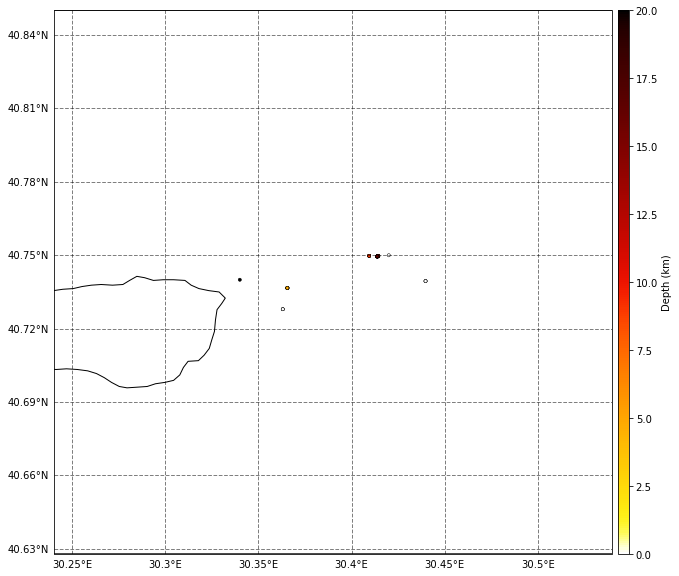

In [13]:
fig = template_group.catalog.plot_map()

## Relocate events

All earthquakes detected with the same template are simply given the template location. However, their actual locations are spread around. Here, we create an `Event` instance for each of the unique events and use `phasenet` and `NLLoc` to relocate them.

In [14]:
import tensorflow as tf

from BPMF.data_reader_examples import data_reader_mseed

# this is necessary to limit the number of threads spawn by tf
os.environ["TF_NUM_INTRAOP_THREADS"] = str(n_CPUs)
os.environ["TF_NUM_INTEROP_THREADS"] = str(n_CPUs)
tf.config.threading.set_inter_op_parallelism_threads(n_CPUs)
tf.config.threading.set_intra_op_parallelism_threads(n_CPUs)
tf.config.set_soft_device_placement(True)

2022-09-26 15:42:42.656085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-09-26 15:42:42.656130: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
# DURATION_SEC: the duration, in seconds, of the data stream starting at the detection time
#               defined by Event.origin_time. This data stream is used for picking the P/S waves.
DURATION_SEC = 60.0
# THRESHOLD_P: probability of P-wave arrival above which we declare a pick. If several picks are
#              declared during the DURATION_SEC data stream, we only keep the best one. We can
#              afford using a low probability threshold since we already know with some confidence
#              that an earthquake is in the data stream.
THRESHOLD_P = 0.10
# THRESHOLD_S: probability of S-wave arrival above which we declare a pick.
THRESHOLD_S = 0.10
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "P"}
# MAX_HORIZONTAL_UNC_KM: Horizontal location uncertainty, in km, above which we keep the template location
MAX_HORIZONTAL_UNC_KM = 10.

In [20]:
events = []
for idx, row in template_group.catalog.catalog.iterrows():
    tid, evidx = row.name.split(".")
    # get the template instance from template_group
    template = template_group.templates[template_group.tindexes.loc[int(tid)]]
    # this is the filename of the database where template tid's detected events were stored
    detection_db_filename = f"detections_template{tid}.h5"
    db_path = os.path.join(BPMF.cfg.OUTPUT_PATH, MATCHED_FILTER_DB)
    with h5.File(os.path.join(db_path, detection_db_filename), mode="r") as fdet:
        keys = list(fdet.keys())
        event = BPMF.dataset.Event.read_from_file(hdf5_file=fdet[keys[int(evidx)]])
    # attach data reader this way (note: conflict with data_reader argument in phasenet's wrapper module)
    event.data_reader = data_reader_mseed
    # pick P-/S-wave arrivals
    event.pick_PS_phases(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP,
        threshold_P=THRESHOLD_P,
        threshold_S=THRESHOLD_S,
        inter_op_parallelism_threads=n_CPUs,
        intra_op_parallelism_threads=n_CPUs,
        data_folder=DATA_FOLDER,
    )
    event.relocate()
    events.append(event)
    if ("NLLoc_reloc" in event.aux_data) and (event.hmax_unc) < MAX_HORIZONTAL_UNC_KM:
        template_group.catalog.catalog.loc[row.name, "longitude"] = event.longitude
        template_group.catalog.catalog.loc[row.name, "latitude"] = event.latitude
        template_group.catalog.catalog.loc[row.name, "depth"] = event.depth

n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


n events: 1, n stations: 8, batch size (n events x n stations): 8


Pred: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


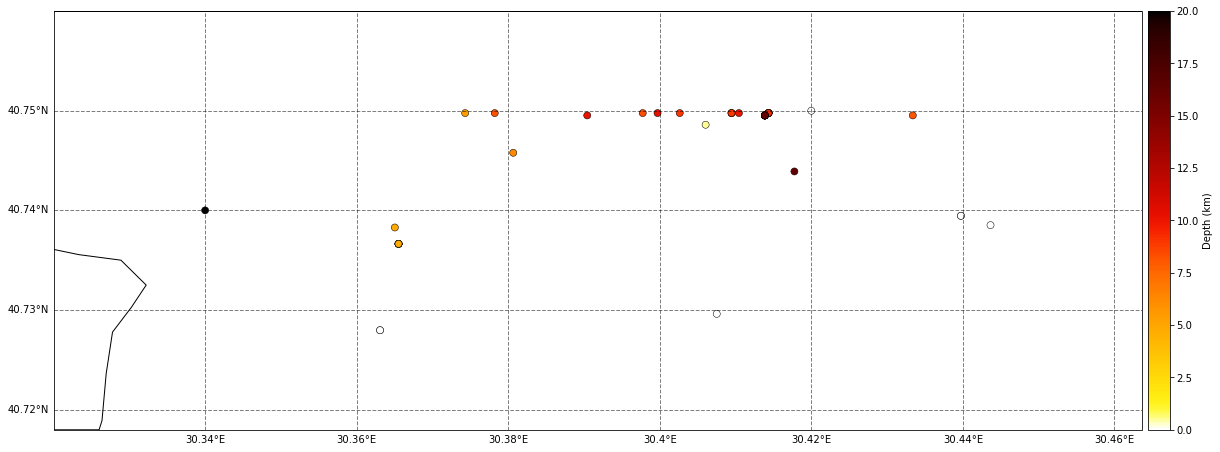

In [29]:
fig = template_group.catalog.plot_map(lat_margin=0.01, lon_margin=0.02, s=50)

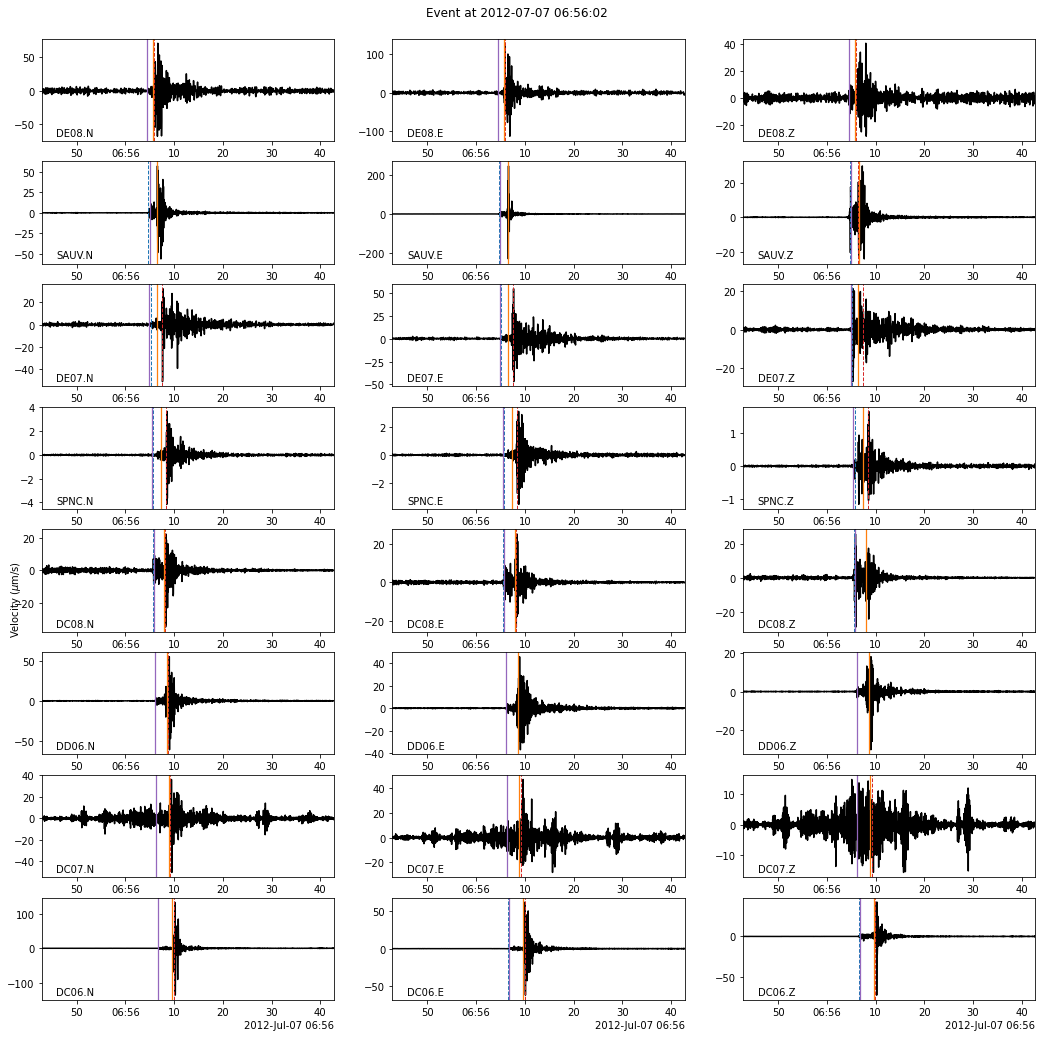

In [21]:
fig = events[0].plot(figsize=(15, 15))

In [26]:
template_group.catalog.longitude - template_group.catalog.catalog.longitude

event_id
0.0     0.0
0.1     0.0
0.2     0.0
3.3     0.0
0.3     0.0
4.3     0.0
4.4     0.0
2.4     0.0
1.6     0.0
1.7     0.0
1.8     0.0
4.7     0.0
2.7     0.0
2.8     0.0
4.9     0.0
0.10    0.0
1.12    0.0
2.9     0.0
4.11    0.0
2.11    0.0
2.12    0.0
4.13    0.0
0.14    0.0
1.15    0.0
6.8     0.0
3.12    0.0
2.14    0.0
4.17    0.0
4.18    0.0
2.17    0.0
2.18    0.0
2.19    0.0
4.20    0.0
2.21    0.0
3.13    0.0
1.20    0.0
4.22    0.0
1.22    0.0
2.24    0.0
6.13    0.0
2.25    0.0
2.26    0.0
2.27    0.0
1.25    0.0
2.28    0.0
5.0     0.0
6.14    0.0
2.29    0.0
2.30    0.0
2.31    0.0
7.0     0.0
1.27    0.0
2.32    0.0
1.28    0.0
Name: longitude, dtype: float64